In [394]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output as clr
import os
import numpy as np

In [832]:
device = "cpu"
if(torch.cuda.is_available()):
    deivce = "gpu"

torch.autograd.set_detect_anomaly(True)

In [845]:
# training
BATCH_SIZE = 100
if(os.path.isdir(os.path.join(os.getcwd(), 'data'))):
    trainset = datasets.MNIST('./data/', train=True, download=False,
                   transform=transforms.ToTensor())
else:
    trainset = datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
print("Done !")

Done !


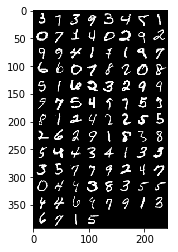

In [846]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images[0])

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
show_images(images)

In [982]:
class VAE_NP(nn.Module):
    def __init__(self, latent_variable_dim, alpha = 1.0):
        super(VAE_NP, self).__init__()
        
        ### Global Params
        # V : Stick breaking : Beta {kumaraswamy}
        self.aeys = nn.Parameter(torch.rand(1,latent_variable_dim) + 1)
        self.bees = nn.Parameter(torch.rand(1,latent_variable_dim) + 1)
        
        self.unif_sampler = torch.distributions.uniform.Uniform(0, 1)
        
        
        # IBP prior
        self.alpha = alpha
        self.euler_constant = np.e
        
        ### Encoder part
        self.fc1 = nn.Linear(784, 400)
        
        # A : Gaussian
        self.weight_enc_mean = nn.Parameter(torch.randn(latent_variable_dim, 400))
        self.weight_enc_std = nn.Parameter(torch.randn(latent_variable_dim, 400))
        
        # Z : Bernoulli
        self.phi = nn.Parameter(torch.randn((784 + 1),latent_variable_dim))
        
        # Gumbel Softmax params
        self.temperature = 10
        self.gumbel_sampler = torch.distributions.gumbel.Gumbel(0,1)
        
        ### Decoder part
        self.weight_dec = nn.Parameter(torch.randn(400, latent_variable_dim, ))
        
        self.fc4 = nn.Linear(400, 784)
    
    def reparameterize_gaussian(self, log_var, mu):
        s = torch.exp(0.5*log_var)
        eps = torch.rand_like(s) - 0.5 # generate a iid standard normal same shape as s
        return eps.mul(s).add_(mu)
    
    def reparameterize_bernoulli(self, inter_z, mask):
        '''Proper Sampling is required with masking'''
        
        N, K = inter_z.shape
        
        U = self.unif_sampler.sample([N,K])
        G0 = self.gumbel_sampler.sample([N,K])
        G1 = self.gumbel_sampler.sample([N,K])
        V = (1-U.pow(1/self.bees)).pow(1/self.aeys)
        logpi = V.log()
        
        for k in range(K):
            logpi[:,k] = logpi[:,:k+1].sum(dim =1)
            
        
        pi = torch.exp(logpi) + 10e-6
        logit_pi = (pi/(1-pi)).log()
        log_alpha = (logit_pi + inter_z).sigmoid()
        
        z0 = (1 - log_alpha + G0)/self.temperature
        z1 = (log_alpha + G1)/self.temperature
        
        y = z1.exp()/(z0.exp() + z1.exp())
        y = y*mask
        
        return y, pi
        
    def forward(self, input, k):
        x = input.view(-1, 784)
        N, D = x.shape
        x = torch.relu(self.fc1(x))
        
        if(k != 0):
            mask = torch.rand_like(self.weight_enc_mean)*0
            mask[:k,:] = 1
            
            mask2 = torch.rand_like(self.phi)*0
            mask2[:,:k] = 1
        else:
            mask = 1
            mask2 = 1
            
        log_s = F.linear(x, self.weight_enc_std*mask)
        m = F.linear(x, self.weight_enc_mean*mask)
        
        inter_z = self.phi*mask2 # 785 x K
        x_cat = torch.cat((input.view(N,784), torch.ones(N).view(N,-1)), 1).view(N,785) # N x 785
        inter_z = torch.mm(x_cat, inter_z) # N x K
        
        z, pi = self.reparameterize_bernoulli(inter_z, mask) # N x K
        
        a = self.reparameterize_gaussian(log_s, m) # N x K
        
        az = a*z
        
        x = self.decode(az, k)
        
        return x, m, log_s, z, pi

    
    def decode(self, z, k):
        
        if(k != 0):
            mask = torch.rand_like(self.weight_dec)*0
            mask[:,:k] = 1
        else:
            mask = 1
        
        x = F.linear(z, self.weight_dec*mask)
        x = torch.sigmoid(self.fc4(x))
        
        
        return x
    
    
    def add_k_node(self, k):
        # Add k latent features ...
        if(k == 0):
            return 
        with torch.no_grad():
            self.aeys = nn.Parameter(torch.cat((self.aeys, torch.rand(1,k) + 1), 1))
            self.bees = nn.Parameter(torch.cat((self.bees, torch.rand(1,k) + 1), 1))
            
            self.phi = nn.Parameter(torch.cat((self.phi, torch.randn((784 + 1),k)), 1))
            
            self.weight_enc_mean = nn.Parameter(torch.cat((self.weight_enc_mean, torch.randn(k, 400)), 0))
            self.weight_enc_std = nn.Parameter(torch.cat((self.weight_enc_std, torch.randn(k, 400)), 0))
            self.weight_dec = nn.Parameter(torch.cat((self.weight_dec, torch.randn(400,k)), 1))
    
    def del_k_node(self, k):
        # Retain k Latent Features ...
        if(k == 0 or k == self.weight_dec.shape[1]):
            return
        with torch.no_grad():
            c_K = self.weight_dec.shape[1]
            
            self.aeys = nn.Parameter(list(torch.split(self.aeys, c_K - k , 1))[0])
            self.bees = nn.Parameter(list(torch.split(self.bees, c_K - k , 1))[0])
            
            self.phi = nn.Parameter(list(torch.split(self.phi, c_K - k , 1))[0])
            
            self.weight_enc_mean = nn.Parameter(list(torch.split(self.weight_enc_mean, c_K - k , 0))[0])
            self.weight_enc_std = nn.Parameter(list(torch.split(self.weight_enc_std, c_K - k , 0))[0])
            self.weight_dec = nn.Parameter(list(torch.split(self.weight_dec, c_K - k , 1))[0])

In [983]:
def loss(input_image, recon_image):
    CE = F.binary_cross_entropy(recon_image, input_image.view(-1, 784), reduction='sum')
    return CE

In [984]:
def retain_k_nodes(model , new_K = 0):
    
    current_K = model.weight_dec.shape[1]
    if(current_K < new_K):
        model.add_k_node(new_K - current_K)
    elif(current_K > new_K):
        model.del_k_node(current_K - new_K)
    else:
        pass
    
    optimizer = torch.optim.Adam(model.parameters())
    
    return optimizer

In [988]:
def get_kth_trunc_loss(model, images, K = 0):
    recon_image, log_var, mu, z, pi = model(images, K)
    
    KL_gauss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    if(K == 0):
        K = model.aeys.shape[1]
    
    KL_kuma = ((model.aeys - model.alpha)/(model.aeys))*(-model.euler_constant -torch.digamma(model.bees) - 1/model.bees)
    KL_kuma += (model.aeys.log() + model.bees.log())
    KL_kuma += -(model.bees - 1)/(model.bees)
    KL_kuma = torch.sum(KL_kuma[:,:K])
    
    log_pz = z*(pi.log()) + (1-z)*((1-pi).log())
    log_qz = -2*(pi/(z.pow(model.temperature)) + (1-pi)/(1 - z.pow(model.temperature)))
    log_qz += pi.log() - (model.temperature + 1)*(z.log()) + (1-pi).log() - (model.temperature + 1)*((1-z).log())
    
    KL_gumb = log_pz - log_qz
    KL_gumb = torch.sum(KL_gumb[:,:K])
    
    ''' Add some more KL terms from K||B ,  '''
    
    
    l = loss(images, recon_image)
    l += KL_gauss
    l += KL_kuma
    l += KL_gumb
    
    
    return l

In [989]:
vae = VAE_NP(40)
optimizer = retain_k_nodes(vae , new_K = 40)

In [ ]:
## train
train_loss = []
for k in range(1,2):
#     optimizer = retain_k_nodes(vae , new_K = k)
    for epoch in range(1):
        for i, data in enumerate(trainloader, 0):
            images, labels = data
            images = images.to(device)
            
            optimizer.zero_grad()
            
            l = get_kth_trunc_loss(vae, images, K = 0)
            l.backward()
            
            train_loss.append(l.item() / len(images))
            optimizer.step()
            
            vae.temperature /= 1.005

            if(i%10 == 0):
                print("Epoch no :", epoch + k, "batch_no :", i)
                clr(wait = True)
        
plt.plot(train_loss)
plt.show()

Epoch no : 1 batch_no : 80


In [963]:
# test
testset = datasets.MNIST('./data/', train=False, download=False,
                   transform=transforms.ToTensor())

testloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

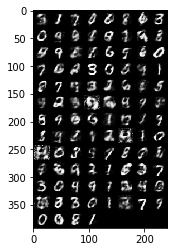

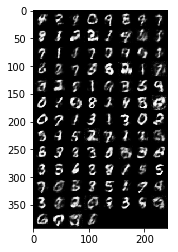

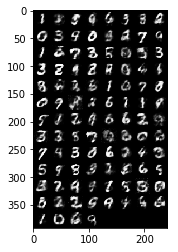

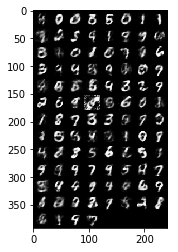

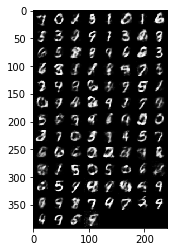

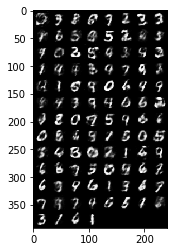

In [964]:
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        images = images.to(device)
        recon_image, s, mu, z = vae(images, 0)
        recon_image_ = recon_image.view(BATCH_SIZE, 1, 28, 28)
        if i % 100 == 0:
            show_images(recon_image_)

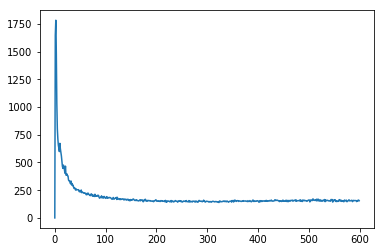

In [969]:
temp = np.array(train_loss)
plt.plot(temp*(temp < 2500))

In [970]:
min(temp[50:])

138.93853515625

In [971]:
vae.aeys

Parameter containing:
tensor([[1.3957, 1.6934, 2.2172, 2.4244, 2.4240, 1.9495, 2.1638, 1.9968, 1.5850,
         1.5464, 2.2223, 1.6499, 1.6852, 1.5812, 1.8882, 2.0345, 1.8936, 2.0298,
         1.4954, 1.5976, 2.4735, 1.8092, 1.7338, 2.2882, 2.3751, 1.7971, 1.7976,
         2.3892, 2.3114, 1.9375, 1.9230, 2.4482, 2.4057, 1.5025, 2.1913, 2.0040,
         1.9633, 1.4940, 2.4850, 1.5841]], requires_grad=True)

In [968]:
vae.bees

Parameter containing:
tensor([[1.0278, 1.7141, 1.0143, 1.3841, 1.5119, 1.4081, 1.6387, 1.5488, 1.5154,
         1.3038, 1.7014, 1.3764, 1.4041, 1.4986, 1.5108, 1.5694, 1.4980, 1.5821,
         1.2616, 1.3156, 1.7424, 1.4842, 1.4281, 1.4307, 1.7910, 1.4593, 1.4492,
         1.5399, 1.6316, 1.4834, 1.4691, 1.8449, 1.6418, 1.3073, 1.6763, 1.5592,
         1.5182, 1.2833, 1.8653, 1.3360]], requires_grad=True)

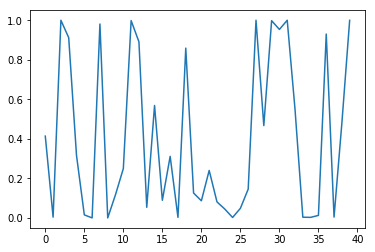

In [979]:
plt.plot(z.numpy()[1,:])